In [1]:
%matplotlib inline

## Recursive Network Exercise

In this exercise, you should train a recursive neural network which can estimate the _free energy_ of an _RNA secondary structure_. In biology, RNA sequences fold to so-called secondary structures and it is assumed that secondary structures are preferred which have little free energy. Free energy is minimized if base pairs are joined in stable pairs.

For this task, though, you do not need to know anything about the actual biological specifics. You can just train a recursive neural net which infers the correct energy (a simple scalar) from a given tree.

### Report

For the report, please describe the architecture that you used to solve the task and generate the following plot. After training the network, generate 100 further trees and record for each tree the size using the `recursive_oracle.tree_size` function and the error `abs(y - y_predicted)`. Plot error against tree size in a scatter plot.

<strong>Note:</strong> Please use the `exercise_sheet_template.tex` to generate your report. Your report is due on *Friday, March 15th, 10am* as single-page PDF to [aschulz@techfak.uni-bielefeld.de](mailto:aschulz@techfak.uni-bielefeld.de). Please start your e-mail subject with the words *[Deep Learning]*.

### Advice

Do not try to map directly to the energy because a one-dimensional encoding may carry too little information. Rather, apply a recursive neural network to a low-dimensional encoding space first and then another neural network which predicts from the encoding the free energy.

Further, this predictive task is not super easy, so do not try to achieve perfect error values. If you manage to stay consistently below an error of 1 this is already a good result.

In [47]:
# For this exercise, we already provide data generation function (an 'oracle')
# which we can use
from recursive_oracle import generate_rna_tree

# let's have a look at an example tree and its energy value.
# Executing this cell multiple times will yield different trees.
x, y = generate_rna_tree()
print('the tree %s has energy value %g' % (str(x), y))

the tree pair(u, pair(g, hairpin(c, hairpin(u, hairpin(g, hairpin_end(u)))), c), g) has energy value 2.56355


In [48]:
# The oracle also provides us with the arity alphabet for the RNA trees
from recursive_oracle import rna_arity_alphabet
print(rna_arity_alphabet)

{'dangle': 2, 'dangle_end': 1, 'split': 2, 'pair': 3, 'branch': 2, 'hairpin': 2, 'hairpin_end': 1, 'c': 0, 'g': 0, 'a': 0, 'u': 0}


In [49]:
import torch
from torch.autograd import Variable

class RecursiveNet(torch.nn.Module):
    def __init__(self, dim, arity_alphabet):
        
        super(RecursiveNet, self).__init__()
        self.dim = int(dim)
        self.arity_alphabet = arity_alphabet
       #self.embed = torch.nn.Embedding(len(arity_alphabet), dim)
        #self.noise = torch.nn.Embedding(len(arity_alphabet), dim)
        self.constants = torch.nn.ParameterDict()
        self.layers = torch.nn.ModuleDict()
        self.Linear = torch.nn.Linear(self.dim, 1)

        for symbol, arity in self.arity_alphabet.items():
            if(arity == 0):
                self.constants[symbol] = torch.nn.Parameter(torch.randn(self.dim))
            else:
                self.layers[symbol] = torch.nn.Linear(arity * self.dim, self.dim)
        self.sigmoid = torch.nn.Sigmoid()
        #self.ReLU = torch.nn.ReLU()
        #self.Hardtanh = torch.nn.Hardtanh()

    def encode(self, T):
        arity = self.arity_alphabet[T.label]
        if(len(T.children) != arity):
            raise ValueError('Expected %s children for a node with label %s but got %d children.' % (
                arity, T.label, len(T.children)))
        if(arity == 0):
            return self.sigmoid(self.constants[T.label])
        
        child_encodings = []
        for child in T.children:
            child_encodings.append(self.encode(child))
            
        child_encodings = torch.cat(child_encodings)
        encoding = self.layers[T.label](child_encodings)
        #encoding = self.embed(Variable(torch.LongTensor([self.arity_alphabet[T.label]])))
        #encoding = self.ReLU(encoding)
        #encoding = self.Linear(encodin)
        return encoding
    
    def forward(self,T):
        encoding = self.encode(T)
        encoding = self.Linear(encoding)
        return encoding

def loss_function(prediction, y_predicted):
    #loss = torch.abs(prediction - target).requires_grad_(True)
    return torch.abs(prediction-y_predicted).requires_grad_(True)

k = 8
#rna_arity_alphabet = {'dangle': 2, 'dangle_end': 1, 'split': 2, 'pair': 3, 'branch': 2, 'hairpin': 2,'hairpin_end': 1, 'c': 0, 'g': 0, 'a': 0, 'u': 0}
model = RecursiveNet(k, rna_arity_alphabet)

#loss_function = torch.nn.L1Loss()


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [51]:
loss_threshold = 1E-2
learning_curve = []

minibatch_size = 50
print(model)
while(not learning_curve or learning_curve[-1] > loss_threshold):
    optimizer.zero_grad()
    
    loss_batch = 0
    for i in range(minibatch_size):
        (x, y) = generate_rna_tree()
        #print(x)
        y_predicted = model(x)
        loss_object = loss_function(y, y_predicted)
        loss_batch += loss_object.item()
        loss_object.backward()

    learning_curve.append(loss_batch / minibatch_size)
    if(len(learning_curve) % 20 == 0):
        print('loss after {} batches: {}'.format(len(learning_curve), learning_curve[-1]))
    optimizer.step()

RecursiveNet(
  (constants): ParameterDict(
      (c): Parameter containing: [torch.FloatTensor of size 8]
      (g): Parameter containing: [torch.FloatTensor of size 8]
      (a): Parameter containing: [torch.FloatTensor of size 8]
      (u): Parameter containing: [torch.FloatTensor of size 8]
  )
  (layers): ModuleDict(
    (dangle): Linear(in_features=16, out_features=8, bias=True)
    (dangle_end): Linear(in_features=8, out_features=8, bias=True)
    (split): Linear(in_features=16, out_features=8, bias=True)
    (pair): Linear(in_features=24, out_features=8, bias=True)
    (branch): Linear(in_features=16, out_features=8, bias=True)
    (hairpin): Linear(in_features=16, out_features=8, bias=True)
    (hairpin_end): Linear(in_features=8, out_features=8, bias=True)
  )
  (Linear): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
loss after 20 batches: 1.4938522344827652
loss after 40 batches: 1.4538879930973052
loss after 60 batches: 1.3951028156280518
loss af

KeyboardInterrupt: 

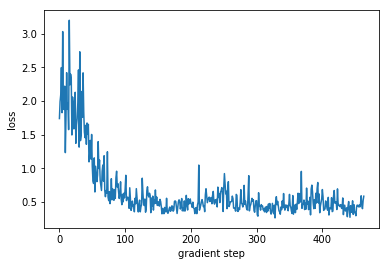

In [54]:
# plot the learning curve

import matplotlib.pyplot as plt

plt.plot(list(range(len(learning_curve))), learning_curve)
plt.xlabel('gradient step')
plt.ylabel('loss')
plt.show()

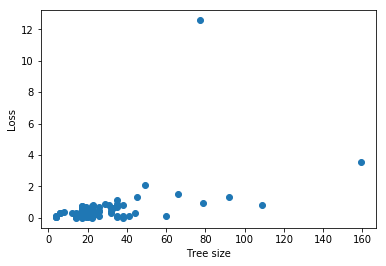

In [53]:
import matplotlib.pyplot as plt
from recursive_oracle import tree_size

session = []
    
model.eval()
with torch.no_grad():
    for i in range(100):
        x, y = generate_rna_tree()
        y_pred = model(x)
        error = abs(y - y_pred).item()
        size = tree_size(x)
        session.append((size, error))
            
plt.scatter([item[0] for item in session], [item[1] for item in session])
plt.xlabel('Tree size')
plt.ylabel('Loss')
plt.show()

In [55]:
for symbol, arity in rna_arity_alphabet.items():
    if(arity > 0):
        w = model.layers[symbol].weight.data[0]
        b = model.layers[symbol].bias.data[0]
        print('weights for symbol \'%s\' = %s ; bias = %s' % (symbol, str(w), str(b)))
    else:
        print('encoding for symbol \'%s\' = %s' % (symbol, str(model.constants[symbol])))

weights for symbol 'dangle' = tensor([-0.2704, -0.4047, -0.3359, -0.3495, -0.4511, -0.3127, -0.2429, -0.1618,
        -0.1598,  0.1904,  0.0341,  0.1647, -0.2226,  0.1749, -0.1367, -0.1964]) ; bias = tensor(-0.5814)
weights for symbol 'dangle_end' = tensor([ 0.3547, -0.2590, -0.2403,  0.4077,  0.1549,  0.0921, -0.0895,  0.2481]) ; bias = tensor(-0.1021)
weights for symbol 'split' = tensor([ 0.0419,  0.0716, -0.0718,  0.1385,  0.0315, -0.1269, -0.1482,  0.2803,
         0.0091,  0.1034,  0.1339,  0.2559,  0.0004, -0.3744, -0.1466,  0.1429]) ; bias = tensor(0.0414)
weights for symbol 'pair' = tensor([-0.1522,  0.1451,  0.3004, -0.2094, -0.0035, -0.2009, -0.1306,  0.4832,
         0.2986, -0.0979, -0.1272, -0.3537,  0.0042, -0.4602,  0.1042,  0.4200,
         0.0389, -0.0185,  0.3939, -0.1801,  0.1659, -0.1738,  0.0061,  0.7007]) ; bias = tensor(-0.1406)
weights for symbol 'branch' = tensor([ 0.0672,  0.0712, -0.1132, -0.0295,  0.0795, -0.2821,  0.1549,  0.2541,
         0.4462,  0.0742, 